<a href="https://colab.research.google.com/github/ML20220207/udemy_TF/blob/main/03_1_Convolutional_Neural_Networks_and_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

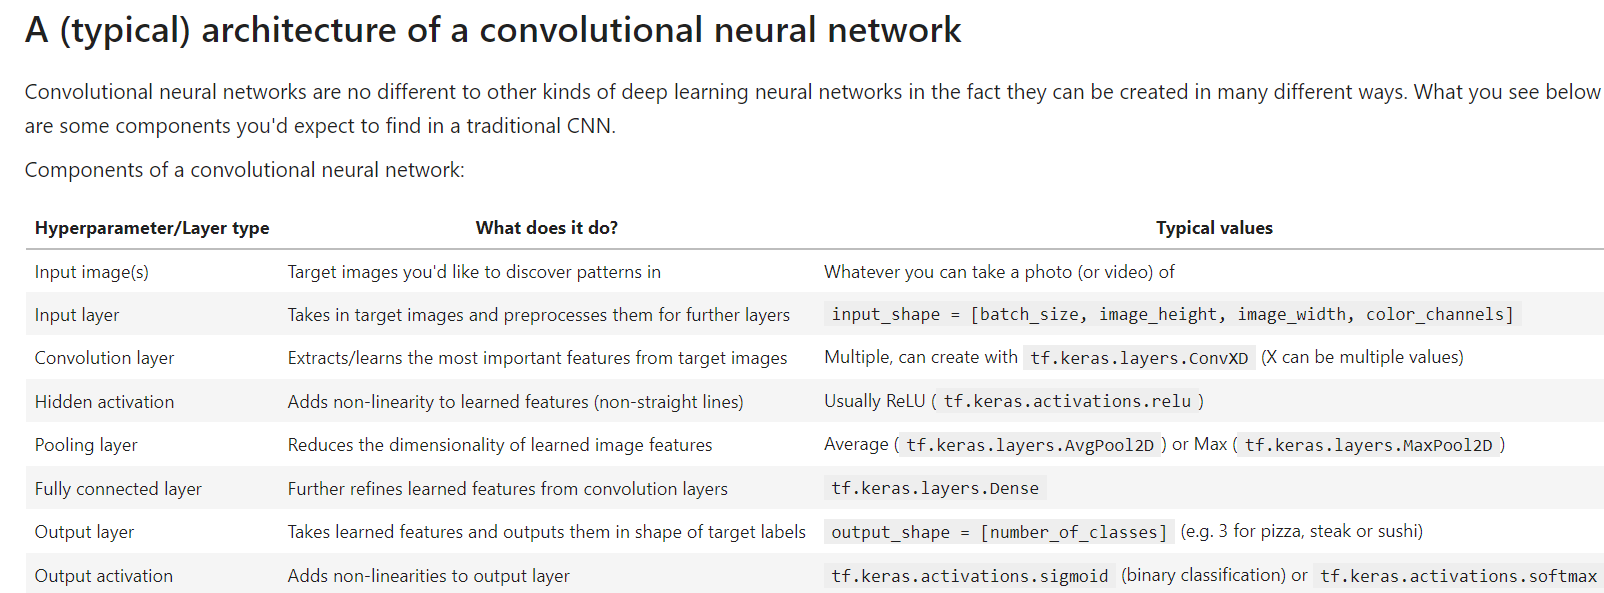

## Data
### download the Data

In [36]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-12 06:02:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M   235MB/s    in 0.4s    

2022-02-12 06:02:57 (235 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



### Inspect the data

In [37]:
!ls pizza_steak

test  train


In [38]:
!ls pizza_steak/train

pizza  steak


In [39]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [40]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print("There are %d directories and %d images in %s" % (len(dirnames), len(filenames), dirpath))

There are 2 directories and 0 images in pizza_steak
There are 2 directories and 0 images in pizza_steak/test
There are 0 directories and 250 images in pizza_steak/test/pizza
There are 0 directories and 250 images in pizza_steak/test/steak
There are 2 directories and 0 images in pizza_steak/train
There are 0 directories and 750 images in pizza_steak/train/pizza
There are 0 directories and 750 images in pizza_steak/train/steak


In [41]:
!ls -la pizza_steak

total 16
drwxr-xr-x 4 root root 4096 Feb 12 04:32 .
drwxr-xr-x 1 root root 4096 Feb 12 06:02 ..
drwxr-xr-x 4 root root 4096 Feb 12 04:32 test
drwxr-xr-x 4 root root 4096 Feb 12 04:32 train


In [42]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [43]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [44]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (384, 512, 3)


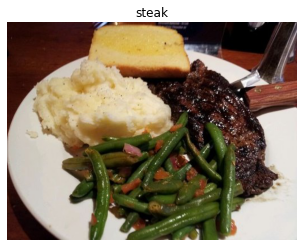

In [45]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [46]:
(img/255.0)[0]

array([[0.14509804, 0.02745098, 0.01960784],
       [0.14509804, 0.02745098, 0.01960784],
       [0.14509804, 0.02745098, 0.01960784],
       ...,
       [0.23921569, 0.20392157, 0.22352941],
       [0.42745098, 0.39215686, 0.41176471],
       [0.4       , 0.36078431, 0.39215686]])


## **An end-to-end example**

In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 12s 244ms/step - loss: 0.5551 - accuracy: 0.6987 - val_loss: 0.3863 - val_accuracy: 0.8520
Epoch 2/5
47/47 [==============================] - 11s 236ms/step - loss: 0.4144 - accuracy: 0.8187 - val_loss: 0.3325 - val_accuracy: 0.8660
Epoch 3/5
47/47 [==============================] - 11s 237ms/step - loss: 0.3830 - accuracy: 0.8280 - val_loss: 0.3493 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 17s 365ms/step - loss: 0.3456 - accuracy: 0.8533 - val_loss: 0.3258 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 16s 334ms/step - loss: 0.3194 - accuracy: 0.8660 - val_loss: 0.3347 - val_accuracy: 0.8640


In [48]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_18 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_20 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

## Binary classification: Let's break it down

1.   Become one with the data (visualize, visualize, visualize...)
1.   Preprocess the data (prepare it for a model)
1.   Create a model (start with a baseline)
2.   Fit the model
2.   Evaluate the model
2.   Adjust different parameters and improve model (try to beat your baseline)
1.  Repeat until satisfied








### 1. Import and become one with the data

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


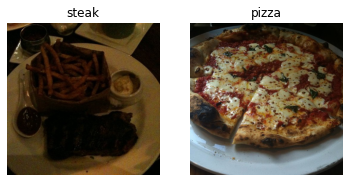

In [49]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### 2. Preprocess the data (prepare it for a model)

In [50]:
# Define training and test directory paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [51]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels), len(train_data), len(train_data)*len(labels)

(32, 32, 47, 1504)

In [52]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.427451  , 0.24313727, 0.07058824],
          [0.4156863 , 0.24313727, 0.06666667],
          [0.39607847, 0.22352943, 0.04705883],
          ...,
          [0.47450984, 0.28235295, 0.12156864],
          [0.48235297, 0.2901961 , 0.12941177],
          [0.48235297, 0.2901961 , 0.12941177]],
 
         [[0.40000004, 0.21568629, 0.04313726],
          [0.4039216 , 0.23137257, 0.05490196],
          [0.427451  , 0.25490198, 0.07843138],
          ...,
          [0.46274513, 0.27058825, 0.10980393],
          [0.46274513, 0.27058825, 0.10980393],
          [0.4666667 , 0.27450982, 0.1137255 ]],
 
         [[0.41176474, 0.227451  , 0.05490196],
          [0.39607847, 0.22352943, 0.04705883],
          [0.39607847, 0.22352943, 0.04705883],
          ...,
          [0.43921572, 0.24705884, 0.08627451],
          [0.45882356, 0.26666668, 0.10588236],
          [0.46274513, 0.27058825, 0.10980393]],
 
         ...,
 
         [[0.38431376, 0.34901962, 0.3137255 ],
          [0.40392

In [53]:
# View the first batch of labels
labels

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.],
      dtype=float32)

### 3. Create a model (start with a baseline)

In [54]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [55]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
    Conv2D(filters = 10,
           kernel_size = 3,
           strides = 1,
           padding = "valid",
           activation = "relu",
           input_shape = (224, 224, 3)),
    Conv2D(10,3,activation = "relu"),
    Conv2D(10,3,activation = "relu"),
    Flatten(),
    Dense(1, activation = "sigmoid")           
])

In [56]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

### 4. Fit a model

In [57]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [58]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 16s 318ms/step - loss: 1.2300 - accuracy: 0.6467 - val_loss: 0.4571 - val_accuracy: 0.7760
Epoch 2/5
47/47 [==============================] - 18s 376ms/step - loss: 0.4443 - accuracy: 0.8067 - val_loss: 0.4195 - val_accuracy: 0.8060
Epoch 3/5
47/47 [==============================] - 12s 262ms/step - loss: 0.3538 - accuracy: 0.8620 - val_loss: 0.4220 - val_accuracy: 0.8140
Epoch 4/5
47/47 [==============================] - 15s 313ms/step - loss: 0.2345 - accuracy: 0.9140 - val_loss: 0.4146 - val_accuracy: 0.8100
Epoch 5/5
47/47 [==============================] - 13s 269ms/step - loss: 0.1199 - accuracy: 0.9667 - val_loss: 0.4086 - val_accuracy: 0.8020


### 5. Evaluate the model

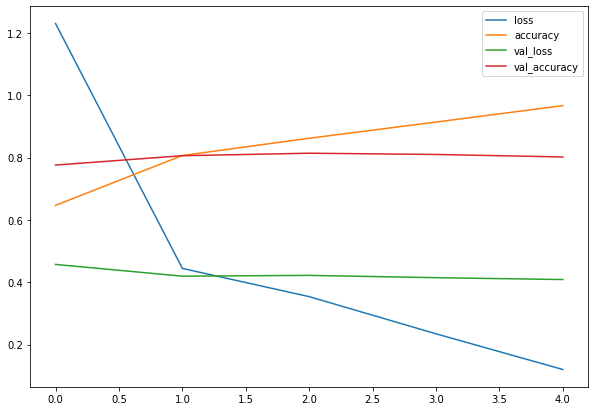

In [59]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

In [60]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

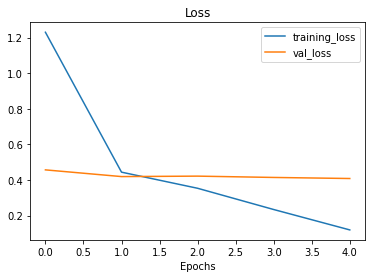

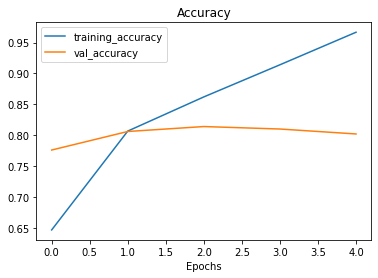

In [61]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

In [62]:
# Check out our model's architecture
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_22 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_23 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_6 (Flatten)         (None, 475240)            0         
                                                                 
 dense_6 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 6. Adjust the model parameters
Fitting a machine learning model comes in 3 steps:


1.   Create a basline.

2.   Beat the baseline by overfitting a larger model.
2.   Reduce overfitting.




In [63]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [64]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [65]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 253ms/step - loss: 0.6832 - accuracy: 0.5587 - val_loss: 0.6428 - val_accuracy: 0.5700
Epoch 2/5
47/47 [==============================] - 10s 217ms/step - loss: 0.5427 - accuracy: 0.7320 - val_loss: 0.4475 - val_accuracy: 0.7740
Epoch 3/5
47/47 [==============================] - 10s 215ms/step - loss: 0.4470 - accuracy: 0.7980 - val_loss: 0.3517 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 10s 219ms/step - loss: 0.3984 - accuracy: 0.8227 - val_loss: 0.3718 - val_accuracy: 0.8480
Epoch 5/5
47/47 [==============================] - 12s 251ms/step - loss: 0.3759 - accuracy: 0.8387 - val_loss: 0.3446 - val_accuracy: 0.8740


In [66]:
# Check out the model architecture
model_5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 10)      

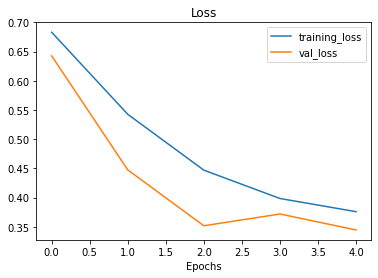

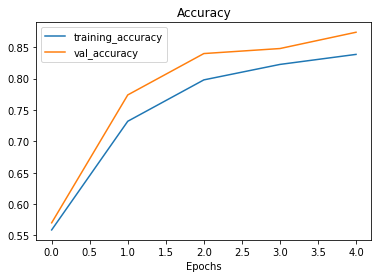

In [67]:
# Plot loss curves of model_5 results
plot_loss_curves(history_5)

In [68]:
## another method of overfitting prevention, data augmentation.
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [69]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [70]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

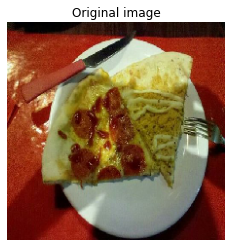

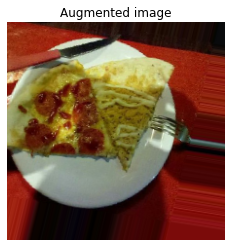

In [71]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

### 7. Repeat until satisified

*   Increase the number of model layers (e.g. add more convolutional layers).
*   Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
*   Train for longer (more epochs).
*   Finding an ideal learning rate.
*   Get more data (give the model more opportunities to learn).
*   Use transfer learning to leverage what another image model has learned and adjust it for our own use case.







## Making a prediction with our trained model

In [72]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


--2022-02-12 06:06:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.05s   

2022-02-12 06:06:47 (34.4 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



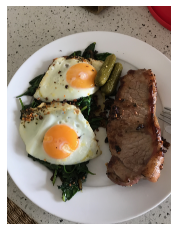

In [73]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [74]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

In [75]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

In [ ]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

In [79]:
# Make a prediction on custom image tensor
pred = model_5.predict(steak)
pred

array([[0.88248986]], dtype=float32)

In [80]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [81]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

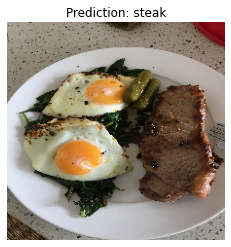

In [83]:
# Test our model on a custom image
pred_and_plot(model_5, "03-steak.jpeg", class_names)

--2022-02-12 06:09:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.1’

03-pizza-dad.jpeg.1 100%[===================>]   2.74M  --.-KB/s    in 0.07s   

2022-02-12 06:09:56 (41.6 MB/s) - ‘03-pizza-dad.jpeg.1’ saved [2874848/2874848]



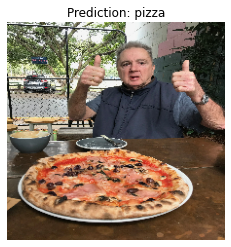

In [85]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(model_5, "03-pizza-dad.jpeg", class_names)

## Multi-class Classification

### 1. Import and become one with the data

In [ ]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [88]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [89]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 512, 3)


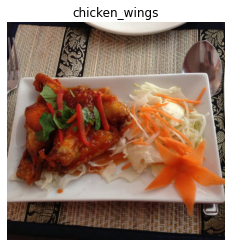

In [90]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

### 2. Preprocess the data (prepare it for a model)

In [91]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a model (start with a baseline)

In [92]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### 4. Fit a model

In [93]:
# Fit the model
history_9 = model_9.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 69s 288ms/step - loss: 2.1265 - accuracy: 0.2261 - val_loss: 1.9358 - val_accuracy: 0.3196
Epoch 2/5
235/235 [==============================] - 66s 281ms/step - loss: 1.8368 - accuracy: 0.3692 - val_loss: 1.8869 - val_accuracy: 0.3484
Epoch 3/5
235/235 [==============================] - 63s 267ms/step - loss: 1.4995 - accuracy: 0.4941 - val_loss: 1.9616 - val_accuracy: 0.3476
Epoch 4/5
235/235 [==============================] - 57s 241ms/step - loss: 0.9365 - accuracy: 0.6951 - val_loss: 2.3475 - val_accuracy: 0.3344
Epoch 5/5
235/235 [==============================] - 67s 284ms/step - loss: 0.3828 - accuracy: 0.8811 - val_loss: 3.0830 - val_accuracy: 0.3040


### 5. Evaluate the model

In [94]:
# Evaluate on the test data
model_9.evaluate(test_data)

79/79 [==============================] - 17s 216ms/step - loss: 3.0830 - accuracy: 0.3040


[3.0829663276672363, 0.30399999022483826]

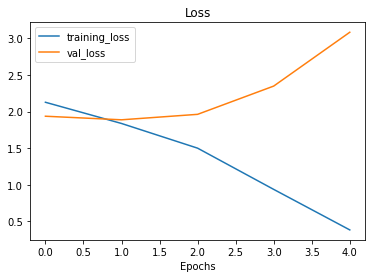

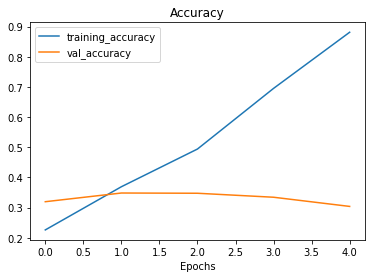

In [95]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from above in the notebook)
plot_loss_curves(history_9)

It seems our model is overfitting the training set quite badly

### 6. Adjust the model parameters
**Get more data** - Having more data gives the model more opportunities to 
learn patterns, patterns which may be more generalizable to new examples.

**Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.

**Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.

**Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

In [96]:
# Try a simplified model (removed two layers)
model_10 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10 = model_10.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 55s 230ms/step - loss: 2.2722 - accuracy: 0.2040 - val_loss: 2.0430 - val_accuracy: 0.2652
Epoch 2/5
235/235 [==============================] - 54s 228ms/step - loss: 1.9325 - accuracy: 0.3244 - val_loss: 1.9815 - val_accuracy: 0.2924
Epoch 3/5
235/235 [==============================] - 51s 216ms/step - loss: 1.7588 - accuracy: 0.3997 - val_loss: 1.9947 - val_accuracy: 0.2976
Epoch 4/5
235/235 [==============================] - 51s 215ms/step - loss: 1.4509 - accuracy: 0.5136 - val_loss: 1.9993 - val_accuracy: 0.3060
Epoch 5/5
235/235 [==============================] - 51s 216ms/step - loss: 1.0033 - accuracy: 0.6800 - val_loss: 2.2893 - val_accuracy: 0.3120


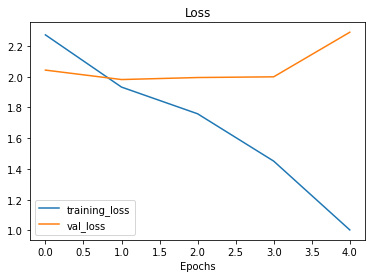

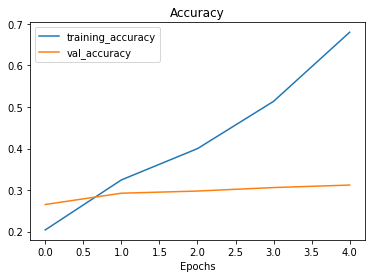

In [97]:
# Check out the loss curves of model_10
plot_loss_curves(history_10)

In [98]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 7500 images belonging to 10 classes.


In [99]:
# Clone the model (use the same architecture)
model_11 = tf.keras.models.clone_model(model_10)

# Compile the cloned model (same setup as used for model_10)
model_11.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_11 = model_11.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 126s 532ms/step - loss: 2.1646 - accuracy: 0.2044 - val_loss: 1.9870 - val_accuracy: 0.3048
Epoch 2/5
235/235 [==============================] - 126s 535ms/step - loss: 2.0553 - accuracy: 0.2687 - val_loss: 1.9182 - val_accuracy: 0.3400
Epoch 3/5
235/235 [==============================] - 126s 534ms/step - loss: 1.9969 - accuracy: 0.2949 - val_loss: 1.8768 - val_accuracy: 0.3460
Epoch 4/5
235/235 [==============================] - 126s 537ms/step - loss: 1.9714 - accuracy: 0.3124 - val_loss: 1.8569 - val_accuracy: 0.3572
Epoch 5/5
235/235 [==============================] - 125s 531ms/step - loss: 1.9332 - accuracy: 0.3315 - val_loss: 1.8270 - val_accuracy: 0.3560


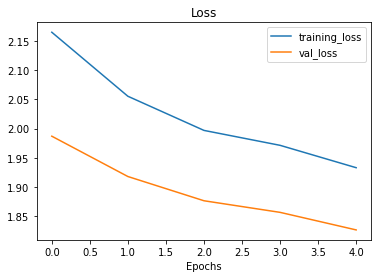

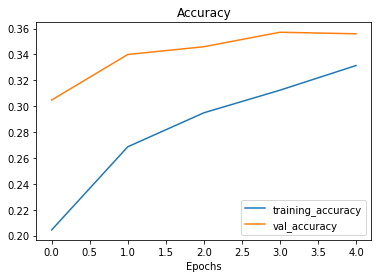

In [100]:
# Check out our model's performance with augmented data
plot_loss_curves(history_11)

### Making a prediction with our trained model

In [101]:
# What classes has our model been trained on?
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [102]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

In [109]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

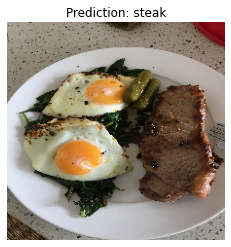

In [110]:
# Make a prediction using model_11
pred_and_plot(model=model_11, 
              filename="03-steak.jpeg", 
              class_names=class_names)

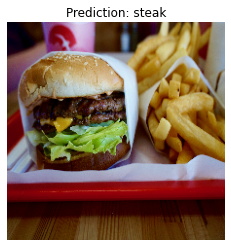

In [111]:
pred_and_plot(model_11, "03-hamburger.jpeg", class_names)

### Saving and loading our model

In [112]:
# Save a model
model_11.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets


In [ ]:
# Load in a model and evaluate it
loaded_model_11 = tf.keras.models.load_model("saved_trained_model")
loaded_model_11.evaluate(test_data)

In [ ]:
# Compare our unsaved model's results (same as above)
model_11.evaluate(test_data)